# differenticalSplicingJunctionExpressionAnalysis as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   This experiment was run with the fastq files from GTEx v8.

The output (read in by section 1.2.1) are matrices which are the result of executing the rmats-nf nextflow workflow on all the samples from GTEx V8 https://github.com/lifebit-ai/rmats-nf.   The workflow begins with the accessions file and continues until a matrix.  Run without statistics, for the purposes of rMATS creating an annotated junction file for each of the five (5) splicing types.  The matrix is possible with this version of rMATS, as the junction ID is unique per annotation GTF.  In this running, we used gencode.v30.annotation.gtf (complete annotation).   The result is 5 matrices per splicing type.

rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

## Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

## There are two different kinds of junction counts

For our analysis here, we used just the jc count matrices.
  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon)

## And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

# 1.0 Loading dependencies

In [1]:
#devtools::install_github("TheJacksonLaboratory/yarn@3ff72c0")
#install.packages("gprofiler2")
library(gprofiler2)
library(downloader)
library(readr)
library(edgeR)
library(biomaRt)
library(DBI) # v >= 1.1.0 required for biomaRt
library(devtools)
library(limma)
library(piggyback)
library(multtest)
library(Biobase)
library(yarn)
library(edgeR)
library(tibble)
#install.packages('R.utils')
library(R.utils)
#install.packages("snakecase")
library(snakecase)

Warning message:
“package ‘downloader’ was built under R version 3.6.3”Warning message:
“package ‘readr’ was built under R version 3.6.3”Loading required package: limma
Warning message:
“package ‘DBI’ was built under R version 3.6.3”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    o

## 1.1 Nextflow execution parameter execution

Using the papermill library, we can parallelize execution of this notebook.  To do this, the loop at the bottom of this notebook should be commented out -- and papermill will run across all tissues fed into it.

In [2]:
# parameters for nextflow execution of notebook
tissue_index = 1

## 1.2 Retrieve Released data

Be sure to set your GITHUB_TOKEN, prior to downloading files

One suggestion is change it to your token and then run it then immediately change it back to this:

Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")

In [3]:
Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")

### Did you remember?

Did you remember to delete your private github token?  Now is a good time to do so, before you save your work and checkit in inadvertantly....

### 1.2.1 rmats_final matrices

In [4]:
getReleasedRMATSData <- function ( destDir ) {

  if (!("rmats_final.se.jc.ijc.txt.gz" %in% list.files(destDir))) {    
    # SE
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    # RI
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.ri.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    # MXE
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.mxe.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    # A3SS
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a3ss.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
     # A5SS
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.inc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.inclen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.a5ss.jc.skiplen.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = destDir)
   }
   return (0)
}

### 1.2.2 get released rMATS GTF annotations

For each splicing type, the junctions are defined, so we have 5 specific annotated splicing specific junction ID annotation files:
fromGTF.A3SS.txt <- annotations for the alternative 3' splice site junctions
fromGTF.A5SS.txt <- annotations for the alternative 5' splice site junctions
fromGTF.MXE.txt <- annotations for the mutually exclusive exon junctions
fromGTF.RI.txt <- annotations for the retained introns junctions
fromGTF.SE.txt <- annotations for the skipped exon junctions

In [5]:
getReleasedGTFAnnotations <- function ( destDir ) {

   if (! (file.exists("../data/fromGTF.tar.gz"))) {
       system("mkdir -p ../data", intern = TRUE)
       message("Fetching fromGTF.tar.gz from GitHub ..")
       # Download archive from GitHub release with tag "dge"
       piggyback::pb_download(file = "fromGTF.tar.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_gtf",
                           tag  = "rMATS.3.2.5.gencode.v30",
                           show_progress = TRUE)
       message("Done!\n")
       message("Decompressing fromGTF.tar.gz into ../data")
       system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
       message("Done!\n")
   }
   return (0)
}


## 1.2.3 Read in SraRunData metadata 

- `Sequence Read Archive (SRA)` Accession Data, `SRR` numbers, this is used to map the SRR accession numbers to the sample information (SAMPID) which will be used to obtain the phenotype information.

In [6]:
getSraRunData <- function ( destDir ) {

  if (!("SraRunTable.txt.gz" %in% list.files(destDir))) {
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "TheJacksonLaboratory/sbas", 
        file = "SraRunTable.txt.gz",
        tag  = "GTExV8.v1.0", 
        dest = destDir)
  }
  message("Loading metadata from SraRunTable.txt.gz ../data/gtex.rds ..\n")
  srr_metadata <- data.table::fread("../data/SraRunTable.txt.gz")
  message("done!\n")
  message("Replacing dashes with dots in sample name")
  srr_metadata$SAMPID <- gsub('-','\\.',srr_metadata$biospecimen_repository_sample_id)
  message("done!\n")
  return(srr_metadata)

}

### 1.2.4 Renew GTEx expression object

- `Genome Tissue Expression (GTEx)` Clinical Annotation - this is the expressionSet object that has the phenotype information
In this analysis there will be 3 expressionSet objects.  This one contains the gene Expression Count Data and phenotypes  -- this is done in two parts, pull it from yarn, and then inspect and correct.

In [7]:
inspectAndCorrectExpressionSetObject <- function ( es ) {

   message("\nBEFORE: dim(exprs(es))[2]\n",
        paste(dim(exprs(es))[2]), collapse=" ")
   message("\nBEFORE: dim(pData(es))[1]\n",
        paste(dim(pData(es))[1]), collapse=" ")
   message("\nBEFORE: dimension of expressionSet\n",
        paste(dim(es)[2]), collapse=" ")

   sample_names=as.vector(as.character(colnames(exprs(es))))
   pheno_sample_names=as.vector(as.character(rownames(pData(es))))
   
   if (length(pheno_sample_names) > length(sample_names)) {
      superset <- pheno_sample_names
      subset   <- sample_names    
   }
   if (length(pheno_sample_names) < length(sample_names)) {
      superset <- sample_names
      subset   <- pheno_sample_names   
   } 
   non_overlaps <- setdiff( superset, subset)
   message("\nThe non-overlapping IDs between pheno and count data are:\n", 
        paste(length(non_overlaps)), collapse = " ")

   logical_match_names=superset %in% subset
   message("\nLogical diff pheno_sample_names, expression_sample_names\n",
        paste(table(logical_match_names)), collapse = " ")

   pData(es) <- pData(es)[logical_match_names==TRUE,]

   message("\nAFTER: dim(exprs(es))[2]\n",
        paste(dim(exprs(es))[2]), collapse=" ")
   message("\nAFTER:: dim(pData(es))[1]\n",
        paste(dim(pData(es))[1]), collapse=" ")
   message("\nAFTER:: dimension of es\n",
        paste(dim(es)[2]), collapse=" ")
   message("Saving corrected gtex.rds..\n")
   saveRDS(es, file="../data/gtex.corrected.rds")   
   message("Generating sha256sum for gtex.corrected.rds ..\n")    
   message(system("sha256sum ../data/gtex.corrected.rds", intern = TRUE))
   message("Done!\n")

   return(es)
}


In [8]:
renewGTExExpressionSet <- function ( destDir ) {
  if (!("gtex.rds" %in% list.files(destDir))) {
      message("Downloading and loading obj with GTEx v8 with 'yarn::downloadGTExV8()'\n")
      es <- yarn::downloadGTExV8(type='genes',file='../data/gtex.rds')
      message("Done!\n")
      message("Generating sha256sum for gtex.rds ..\n")    
      message(system("sha256sum ../data/gtex.rds", intern = TRUE))
      message("Done!\n")
      message("running inspectAndCorrectExpressionSet to generate gtex.corrected.rds\n")
      es <- inspectAndCorrectExpressionSetObject (es)
      message("Done!\n")
      
  } else {
    # Load with readRDS() if gtex.rds available in data/
      message("Loading obj GTEx v8 corrected rds object with readRDS from ../data/gtex.corrected.rds\n")   
      es <- readRDS(file = "../data/gtex.corrected.rds")
      message("Done!\n")
      message("Generating sha256sum for gtex.corrected.rds ..\n")    
      message(system("sha256sum ../data/gtex.corrected.rds", intern = TRUE))
      message("Done!\n")
  }
  return (es)

}

### 1.2.5 get gtex.corrected.rds

In [9]:
getGTExCorrectedRDS <- function ( destDir ) {

  if (!("gtex.corrected.rds" %in% list.files(destDir))) {
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "TheJacksonLaboratory/sbas", 
        file = "gtex.corrected.rds",
        tag  = "GTExV8.v1.0", 
        dest = destDir)
  }
  message("Loading gtex.corrected.rds ..\n")
  es <- readRDS(file = "../data/gtex.corrected.rds")
  message("done!\n")
  return(es)

}

### 1.2.6 get reduced Tissue Data

Stored in the assets subdirectory, reduced by inspection and selection focusing on those tissues with sufficient samples.

In [10]:
getTissueReduction <- function ( filename ) {

    tissue_reduction <- read.table(filename, header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
    colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")

    return(tissue_reduction)
}

### 1.2.7 make phenotype data matrix portion of ExpressionSet (makePData)

Matching SraRunTable, Sequence Read Archive Sequence Run accession number, SRR to the sample, SAMPID, that will be used to match the SRR to the samples phenotype information to make the phenotype data portion of the expressionSet object.

counts data supplies the SRR through the column
Metadata from the SraRunTable.txt file matches the SRR to the SAMPID
Phenotype data retrieved from the GTEx gene ExpressionSet data object for that SAMPID

SRR -> SAMPID -> Phenotype Data

This routine takes a while to run, could be improved by changing it to a lapply function.
Luckily, this needs only to be run once for all 10 matrices since the ijc, sjc counts were done on the same samples and defined alternative splicing events.

In [11]:
makePData <- function (counts_srr, gtexPhenoDataObj, srr_metadata) {
    started = FALSE
    srr_missing = FALSE
    pd_missing = FALSE
    for (i in 1:length(counts_srr)) {
        #
        # SraRunTable connects SRR to SAMPID
        #
        srr_metadata_match <- as.character(srr_metadata$Run) %in% as.character(counts_srr[i])
        if (sum(srr_metadata_match) < 1){
            srr_metadata_missing <- as.character(srr_metadata$Run) 
            message("no match srr_metadata$Run! ERROR!")
            if (!srr_missing) {
                srr_metadata_missing_list <- srr_metadata_missing
                srr_missing = TRUE
            } else {
                srr_metadata_missing_list <- rbind(srr_metadata_missing_list, srr_metadata_missing)
            }
        } else {
            srr_metadata_sampid <- srr_metadata[srr_metadata_match==TRUE,]$SAMPID
#            message("\nsrr_metadata_sampid\n",
#               paste(srr_metadata_sampid), collapse=" ")
            #
            # SAMPID is used to match SRR to Phenotype Data for GTEx
            #
            pd_sampid_match <- as.character(pData(gtexPhenoDataObj)$SAMPID) %in% as.character(srr_metadata_sampid)
#           message("\npd_sampid_match table\n",
#               paste(table(pd_sampid_match)), collapse=" ")
#           message("\nsum(pd_sampid_match)\n",
#               paste(sum(pd_sampid_match)), collapse = " ")
            if (sum(pd_sampid_match) < 1 ) {
#               message("no pd_sampid match to srr_metadata_sampid!\n")
                pd_sampid_missing <- as.character(srr_metadata_sampid)
                if (!pd_missing) {
                    pd_sampid_missing_list <- pd_sampid_missing
                    pd_missing = TRUE
                } else {
                    pd_sampid_missing_list <- rbind(pd_sampid_missing_list, pd_sampid_missing)
                }
            }  else {
                pd     <- pData(gtexPhenoDataObj)[pd_sampid_match,]
                srr_metadata_srr <- srr_metadata[srr_metadata_match==TRUE,]$Run
                pd$SRR <- srr_metadata_srr
                if (started == TRUE) {
                    pdfinal <- rbind(pdfinal, pd)
                } else {
                    pdfinal <- pd
                    started = TRUE
                }
            } # end if pd_sampid_match
        } # end if srr_metadata_match
    }# end for loop

    pdfinal_filename           <- paste0(paste0("../data/", counts_name), "pdata.csv")
    if (srr_missing) {
        metadata_missing_filename  <- paste0(paste0("../data/", counts_name), "srr_metadata_missing.csv")
        write.csv(srr_metadata_missing_list, metadata_missing_filename , quote=FALSE, row.names=FALSE)
    }
    if (pd_missing) {
        pd_sampid_missing_filename <- paste0(paste0("../data/", counts_name), "pd_sampid_missing.csv")
        write.csv(pd_sampid_missing_list   , pd_sampid_missing_filename, quote=FALSE, row.names=FALSE)
    }
    write.csv(pdfinal                  , pdfinal_filename          , quote=FALSE, row.names=FALSE)
    return(pdfinal)
}

### 1.2.8 get GTEx phenotype data for the SRR accessions
Transitive closure permits the association of the sequence reads, SRR Accessions, through the SraRunTable.txt (obtained from selecting annotation from the dbGaP login) with the SAMPID used with the GTEx.  This SAMPID is the means by which we can get this phenotype data and associate it with the counts data.

If the data has not yet been retrieved, we can pull it from the release, using piggyback.   Input to this function can be any one of the 10 count matrices, since all were produced on the same samples

In [12]:
getGTExPhenoDataForSRR <- function (destDir) {
    if (!("srr_pdata.csv" %in% list.files(destDir))) {
        piggyback::pb_download(
               show_progress = TRUE,
               repo = "TheJacksonLaboratory/sbas", 
               file = "srr_pdata.csv",
               tag  = "GTExV8.v1.0", 
               dest = destDir)
        message("Loading srr_pdata\n")
        srr_pdata <- readr::read_csv("../data/srr_pdata.csv")
        message("done!\n")
    } else {
        message("Loading srr_pdata\n")
        srr_pdata <- readr::read_csv("../data/srr_pdata.csv")
        message("done!\n")
    }
    return(srr_pdata)
}

### 1.2.9 makeCountsMatrix 

Given the counts filename, make a data matrix.

In [13]:
makeCountsMatrix <- function (filename_gz) {
    message("\nloading ", paste(filename_gz), collapse=" ")
    counts <- data.table::fread(filename_gz)
    message("done!")
    rownames(counts) <- counts$ID
    counts <- counts[,-1]
    counts <- data.matrix(counts)
    return(counts)
}


### 1.2.10 makeSplicingExpressionSetObject 

Given the phenotype data object for each of the count matrices, create an expressionSet object for each to facilitate analysis.

In [14]:
makeSplicingExpressionSetObject <- function (srr_pdata, counts) {
    message("making splicing expressionSet object")
    #
    # match srr counts with srr_pdata - there were some srr without phenodata
    #
    pdata_match <- as.character(colnames(counts)) %in% as.character(srr_pdata$'SRR')
    
    counts <- counts[,pdata_match]

    #
    # reorder the srr_pdata to match the colnames of the counts
    #
    reorder_idx <- match(as.character(colnames(counts)), as.character(srr_pdata$'SRR'))
    srr_pdata   <- srr_pdata[reorder_idx,]

    #
    # make the srr_pdata an AnnotatedDataFrame
    #
    metadata <- data.frame(labelDescriptions=as.character(colnames(srr_pdata)))
    phenoData <- new("AnnotatedDataFrame", data = srr_pdata, varMetadata=metadata)

    #
    # make the counts an expressionSet
    # and provide the phenoData (the annotatedDataFrame construct from above)
    #
    es <- ExpressionSet(as.matrix(counts))
    phenoData(es) <- phenoData
    
    message("made new expressionSet object\n",
           paste(dim(es)), collapse = " ")
    message("dim pData(es)\n",
           paste(dim(pData(es))), collapse = " ")
    message("dim exprs(es)\n",
           paste(dim(exprs(es))), collapse = " ")
    message("done!\n")
    
    return(es)
}

### 1.2.11 getDGEResults 

Using the output of the differentialGeneExpression analysis, we will screen those genes differentially expressed prior to performing the linear regression.

In [15]:
getDGEResults <- function ( destDir ) {

   if (! (file.exists("../data/DGE_gene_csv.tar.gz"))) {
       system("mkdir -p ../data", intern = TRUE)
       message("Fetching DGE_gene_csv.tar.gz from GitHub ..")
       # Download archive from GitHub release 
       piggyback::pb_download(file = "DGE_gene_csv.tar.gz",
                           dest = "../data",
                           repo = "TheJacksonLaboratory/sbas",
                           tag  = "GTExV8.DGE.v1.1",
                           show_progress = TRUE)
       message("Done!\n")
       message("Decompressing DGE_gene_csv.tar.gz into ../data")
       system("mkdir -p ../data && tar xvfz ../data/DGE_gene_csv.tar.gz -C ../data", intern = TRUE)
       message("Done!\n")
   }
   return (0)
}


## 1.3 Preprocessing 


### 1.3.1  Reduce Sample Set 
Read in all requirements so that the stage is properly set -- tissues.tsv contains the subset of files desired for analysis.
It is found in the `assets` subdirectory

In [16]:
reduceSampleSet <- function (tissue_reduction, es) {

    message("\nsize tissue_reduction\n",
        paste(dim(tissue_reduction), collapse=" "))
   message("\nsize es\n",
        paste(dim(es)), collapse=" ")
   message("\nsize pData(es)\n",
        paste(dim(pData(es)), collapse=" "))
   # only include those tissues we wish to continue with
   message("\n number of tissue types to keep\n",
        paste(table(tissue_reduction$include)), collapse = " ")
   tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

   # create a matching tissue name to go with the expressionSet phenotype esect
   pData(es)$SMTSD        <- factor(snakecase::to_snake_case(as.character(pData(es)$SMTSD)))
   tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))

   message("\nlength tissues in phenotype data\n",
        paste(length(levels(pData(es)$SMTSD)), collapse = " "))
   message("\nlength tissues in tissue_reduction data\n",
        paste(length(tissue_reduction$SMTSD), collapse = " "))

   keep <- pData(es)$SMTSD %in% tissue_reduction$SMTSD
   message("\nhow many to keep in phenotype data\n",
        paste(table(keep), collapse = " "))

   es        <- es       [          ,keep==TRUE]
   pData(es)$SMTSD <- factor(pData(es)$SMTSD)
   message("\nsize reduced es\n",
        paste(dim(es)), collapse=" ")
   message("\nsize pData(es)\n",
        paste(dim(pData(es)), collapse=" "))
   message("\nsize exprs(es)\n",
        paste(dim(exprs(es)), collapse = " "))

   # test to make sure we don't have nonsense
   keep = pData(es)$SMTSD== "breast_mammary_tissue"
   message("\nTEST: how many to keep in to have only breast_mammary_tissue\n",
        paste(table(keep), collapse = " "))
   tes        = es       [          ,keep==TRUE]
   pData(tes) = pData(es)[keep==TRUE,          ]
   message("\nTEST: size breast_mammary_tissue tes\n",
        paste(dim(tes), collapse=" "))
   message("\nTEST: size phenotype object pData(tes)\n",
        paste(dim(pData(tes)), collapse=" "))
   # end test
   return (es)
}

### 1.3.2 Eliminate ChrY fromGTF

We are studying the sex-biased differences, to do this we need to eliminate chromosome Y, this is not shared between the sexes

In [17]:
eliminateChrYfromGTF <- function ( fromGTF ) {

   fromGTF.keepAllButChrY <- (fromGTF$chr != "chrY")
   fromGTF           <- fromGTF[fromGTF.keepAllButChrY,]
   rownames(fromGTF) <- fromGTF$ID
   return(fromGTF)
}

### 1.3.3 Eliminate ChrY from expressionSet Object

We are studying the sex-biased differences, to do this we need to eliminate chromosome Y, this is not shared between the sexes
This time from the expressionSet Object

In [18]:
eliminateChrYfromExpressionSet <- function ( fromGTF, es ) {

    es_row_ids <- rownames(es)
    gtf_ids <- fromGTF$ID
    keep <- es_row_ids %in% gtf_ids
   
    es   <- es[keep == TRUE, ]
    message("remade the expressionSet object\n",
           paste(dim(es)), collapse = " ")
    message("dim pData(es)\n",
           paste(dim(pData(es))), collapse = " ")
    message("dim exprs(es)\n",
           paste(dim(exprs(es))), collapse = " ")
    message("done!\n")

    return(es)
}

### 1.3.4 Remove DGE genes from expressionSet Obj

DGE are removed prior to the construction of the linear model.  It is assumed that the DGE files were obtained from the release.  Using these results, we will remove the junction rows corresponding to those genes.

In [19]:
removeDGEGenes <- function ( tissue_of_interest, fromGTF, es ) {

    #
    # read in the DGE refined list to get the differentially expressed genes for this tissue
    #
    filename <- paste0(paste0("../data/",tissue_of_interest), "_DGE_ensg_map.csv")
    dge_list <- readr::read_csv(filename)
    gtf_id_match <- as.character(fromGTF$geneSymbol) %in% as.character(dge_list$ensg_genes)
    message("\n DGEs in tissue of interest remove this many", 
           paste(table(gtf_id_match)), collapse=" ")    
    #
    # we want to keep all that do not match
    #
    gtf_ids <- fromGTF$ID[!gtf_id_match]
    es_row_ids <- rownames(es)
    keep <- es_row_ids %in% gtf_ids
   
    es   <- es[keep == TRUE, ]
    message("remade the expressionSet object\n",
           paste(dim(es)), collapse = " ")
    message("dim pData(es)\n",
           paste(dim(pData(es))), collapse = " ")
    message("dim exprs(es)\n",
           paste(dim(exprs(es))), collapse = " ")
    message("done!\n")

    return(es)
}

## Exploratory and Differential analysis as_event:ijc, sjc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the included exon junction count expression; sex denotes the reported sex of the subject

## Differential analysis as_event (combined ijc and sjc)

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + B2 as_event + B3 sex*as_event + epsilon (error)
           

where y is the alternative splicing event expression; sex denotes the reported sex of the subject, as_event represents the specific alternative splicing event - either included exon junction counts or skipped exon junction counts and their interaction terms.   Donor is added to our model as a blocking variable used in both the calculation of duplicate correlation as well as in the linear fit.

### Voom, limma's lmFit and eBayes

Using sample as a blocking variable, we are able to model the effects of the donor on the results, which improves the power.  This topic is discussed in biostars https://www.biostars.org/p/54565/.  And Gordon Smyth answers the question here https://mailman.stat.ethz.ch/pipermail/bioconductor/2014-February/057887.html.  The method of modeling is a random effects approach in which the intra-donor correlation is incorporated into the covariance matrix instead of the linear predictor.   And though as Gordon Smyth states both are good method and the twoway anova approach makes fewer assumptions, the random effects approach is statistically more powerful.  

We have a balanced design in which all donors receive all stimuli (which is really in healthy human donors, life and all of its factors!) Our measurement has so many points -- we are measuring in the skipped exon approach, 42,611 junctions!   It is not possible to encorporate those measurements into the linear predictor.  A two-way ANOVA approach is virtually as powerful as the random effects approach 
and hence is preferable as it makes fewer assumptions.

For an unbalanced design in which each donor receives only a subset of the stimula, the random effects approach is more powerful.

Random effects approach is equivalent to The first method is twoway anova, a generalization of a paired analysis.

The ijc and sjc are expressionSet objects:
 counts are obtained from exprs(ijc) and exprs(sjc)
 
 operations at the main object level will ripple to the phenotype and expression set information.
 so filtering occurs on the expressionSet object ijc and sjc

In [20]:
print_exploratory_plots <- function (plot, dup, tissue_of_interest, splice_type, fromGTF, tissue_list, ijc, sjc) {

    fromGTF           <- fromGTF
    tissue_true       <- tissue_list == tissue_of_interest

    message("\nLimiting phenotype data to tissue of interest\n",
           paste(tissue_of_interest),collapse=" ")    
    keep = pData(ijc)$SMTSD== tissue_of_interest
    message("\nkeep\n",
           paste(table(keep)),collapse=" ")
    ijc <- ijc[,keep==TRUE]
    sjc <- sjc[,keep==TRUE]

    message("\ndimensions of the ijc_tissue \n", 
        paste(  dim(ijc), collapse = " ") )
    message("\ndimensions of the sjc_tissue \n", 
        paste(  dim(sjc), collapse = " ") )

    #
    # ensure the matrices do not have too many zeros
    #
    ijc.rs <- rowSums(exprs(ijc)) 
    keep.ijc.rs <- (ijc.rs > 10)
    sjc.rs <- rowSums(exprs(sjc)) 
    keep.sjc.rs <- (sjc.rs > 10)
    keep <- keep.ijc.rs | keep.sjc.rs
    message("\nijc.rs > 10 \n", 
        paste(table(keep.ijc.rs), collapse = " ") )                    
    message("\nsjc.rs > 10 \n", 
        paste(table(keep.sjc.rs), collapse = " ") )
    message("\nkeep combined ijc | sjc \n", 
        paste(table(keep), collapse = " ") )                    
    
    ijc <- ijc[keep==TRUE,]
    sjc <- sjc[keep==TRUE,]
    message("\ndim(ijc)\n", 
        paste(dim(ijc), collapse = " ") )                    
    message("\ndim(sjc)\n", 
        paste(dim(sjc), collapse = " ") )
    
    message("\nsex samples:\n",
        paste(table(pData(ijc)$SEX)), collapse="\n")

    design    <- model.matrix ( ~ pData(ijc)$SEX)
    message("\ndesign matrix ijc, alone:\n",
        paste0(head(design), collapse="\n"))

    colnames(design) <- c("intercept","sex")

    y_ijc <- DGEList(counts=exprs(ijc), group = pData(ijc)$SEX)
    y_ijc <- calcNormFactors(y_ijc, method="RLE")
    y_ijc_voom <- voom (y_ijc, design=design, plot=plot)

    Gender <- ifelse(pData(ijc)$SEX==1,"m","f")
    pdf_sub_directory = '../pdf/'
    csv_sub_directory = '../data/'
    
    filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                                     snakecase::to_snake_case(tissue_of_interest)),"-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_ijc, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                                     snakecase::to_snake_case(tissue_of_interest)),"-ijc-voom-MDSplot-100.pdf")
    pdf (filename)    
        plotMDS(y_ijc_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
 
    fit_ijc <- lmFit(y_ijc_voom, design)
    fit_ijc <- eBayes(fit_ijc)

    ijc_sex_results                    <- topTable(fit_ijc, coef='sex', number=nrow(y_ijc_voom))
    ijc_sex_results_refined            <- ijc_sex_results$adj.P.Val <= 0.05 & abs(ijc_sex_results$logFC) >= abs(log2(1.5))
    ijc_sex_rnResults                  <- rownames(ijc_sex_results)
    ijc_sex_resultsAnnotations         <- fromGTF[ijc_sex_rnResults,]

    ijc_sex_results_refinedAnnotations <- ijc_sex_resultsAnnotations[ijc_sex_results_refined ==TRUE,]
    message("\ndimensions of the ijc_sex_results_refined_annotations \n", 
        paste(dim (ijc_sex_results_refinedAnnotations), collapse = " ") )

    # geneSymbols are in the annotations 
    ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol
    ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol
    message("\nlength ijc_sex_results_refined_geneSymbols\n", 
        paste(length(ijc_sex_refined_geneSymbols), collapse = " ") )

    # adjust the rownames to be the geneSymbols rather than junction IDs
    ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
    rownames(ijc_sex_results)  <- ijc_sex_results_rn    

    ijc_sex_filename               = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_ijc_sex.csv',sep='')
    ijc_sex_refined_filename       = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_ijc_sex_refined.csv',sep='')
    ijc_sex_genesFilename          = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_ijc_sex_universe.txt',sep='')
    ijc_sex_refined_genesFilename  = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_ijc_sex_gene_set.txt',sep='')
    write.table(ijc_sex_results, 
                file = ijc_sex_filename        , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(ijc_sex_results [ijc_sex_results_refined      ,], 
                file = ijc_sex_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(ijc_sex_geneSymbols,        
                file = ijc_sex_genesFilename        , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(ijc_sex_refined_geneSymbols,
                file = ijc_sex_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
   
    message("\nstarting sjc\n")

    # the pData object for ijc was used for the annotation - they are the same for ijc and sjc
    y_sjc <- DGEList(counts=exprs(sjc), group = pData(ijc)$SEX)
    y_sjc <- calcNormFactors(y_sjc, method="RLE")
    y_sjc_voom <- voom (y_sjc, design=design, plot=plot)

    Gender <- ifelse(pData(ijc)$SEX==1,"m","f")
    filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                                     snakecase::to_snake_case(tissue_of_interest)),"-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_sjc, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                                     snakecase::to_snake_case(tissue_of_interest)),"-sjc-voom-MDSplot-100.pdf")
    pdf (filename)    
        plotMDS(y_sjc_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
 
    fit_sjc <- lmFit(y_sjc_voom, design)
    fit_sjc <- eBayes(fit_sjc)

    sjc_sex_results                    <- topTable(fit_sjc, coef='sex', number=nrow(y_sjc_voom))
    sjc_sex_results_refined            <- sjc_sex_results$adj.P.Val <= 0.05 & abs(sjc_sex_results$logFC) >= abs(log2(1.5))
    sjc_sex_rnResults                  <- rownames(sjc_sex_results)
    sjc_sex_resultsAnnotations         <- fromGTF[sjc_sex_rnResults,]

    sjc_sex_results_refinedAnnotations <- sjc_sex_resultsAnnotations[sjc_sex_results_refined      ==TRUE,]
    message("\ndimensions of the sjc_sex_results_refined_annotations \n", 
        paste(dim (sjc_sex_results_refinedAnnotations), collapse = " ") )

    # geneSymbols are in the annotations 
    sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol
    sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol
    message("\nlength sjc_sex_results_refined_geneSymbols\n", 
        paste(length(sjc_sex_refined_geneSymbols), collapse = " ") )

    # adjust the rownames to be the geneSymbols rather than junction IDs
    sjc_sex_results_rn         <- paste(sjc_sex_geneSymbols, sjc_sex_rnResults, sep="-")
    rownames(sjc_sex_results)  <- sjc_sex_results_rn    

    sjc_sex_filename               = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sjc_sex.csv',sep='')
    sjc_sex_refined_filename       = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sjc_sex_refined.csv',sep='')
    sjc_sex_genesFilename          = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sjc_sex_universe.txt',sep='')
    sjc_sex_refined_genesFilename  = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sjc_sex_gene_set.txt',sep='')
    write.table(sjc_sex_results, 
                file = sjc_sex_filename        , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sjc_sex_results [sjc_sex_results_refined      ,], 
                file = sjc_sex_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sjc_sex_geneSymbols,        
                file = sjc_sex_genesFilename        , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sjc_sex_refined_geneSymbols,
                file = sjc_sex_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    
    message("removing DGE Genes prior to making y linear model")
    ijc <- removeDGEGenes(tissue_of_interest <- tissue_of_interest, fromGTF <- fromGTF, es <- ijc)
    sjc <- removeDGEGenes(tissue_of_interest <- tissue_of_interest, fromGTF <- fromGTF, es <- sjc)
    
    message("starting the y prediction\n")
    sample_names <- as.character(pData(ijc)$SAMPID)
    # we will add donor as a blocking parameter
    # rather than sample name -- we should use donor for real
    sample     <- factor(sample_names)
    
    donor    <- rep(sample, 2)
    message("\ndonor size", 
        paste(length(donor)), collapse = " ") 

    as_matrix <- cbind(exprs(ijc),exprs(sjc))
    message("\ndim as_matrix", 
        paste(dim(as_matrix)), collapse = " ")
            
    message("sex samples:\n",
        paste(table(pData(ijc)$SEX)), collapse=" ")
    sex2      <- factor(c(rep(pData(ijc)$SEX,2)))
    message("sex samples:\n",
        paste(table(sex2)), collapse = " ")
    message("\nlength sex2\n", 
        paste(length(sex2)), collapse = " ") 

    as_event  <- c(rep("ijc",dim(ijc)[2]), rep("sjc", dim(sjc)[2]))
    as_event  <- factor(as_event, levels=c("ijc", "sjc"))
    message("\nlength as_event\n", 
        paste(length(as_event)), collapse = " ")

    design    <- model.matrix( ~ sex2 + as_event + sex2*as_event)

    colnames(design) <- c("intercept","sex", "as_event","sex*as_event")
    message("\ndim design <- model.matrix( ~sex + as_event + sex*as_event)\n", 
        paste(head(design), collapse = "\n") )

    y <- DGEList(counts=as_matrix, group = sex2)
    y <- calcNormFactors(y, method="RLE")
    y_voom <- voom (y, design=design, plot = plot)

    if (dup==TRUE) {
        dup_cor <- duplicateCorrelation(y_voom$E, design=design, ndups=2, block=donor, weights=y$samples$norm.factors)
        dup_cor$consensus.correlation 
        y_dup_voom <- voom (y, design=design, plot = plot, block = donor, correlation = dup_cor$consensus.correlation) 
    }
    
    Gender <- ifelse(pData(ijc)$SEX==1,"m","f")
    message("\nGenders new size\n", 
        paste(length(Gender), collapse = " ") )
    message("\nplotting y for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event\n")
     # print the combined exploratory plot
    filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y[,c(1:dim(ijc)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    message("\nplotting y_voom for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event\n")
    filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-voom-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_voom[,c(1:dim(ijc)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    if (dup == TRUE) {
        filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                           snakecase::to_snake_case(tissue_of_interest)),"-y-dup-voom-ijc-MDSplot-100.pdf")
        pdf (filename)
            plotMDS(y_dup_voom[,c(1:dim(ijc)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
        dev.off()
    }
    message("\nplotting y for sjc portion of design <- model.matrix( ~sex + as_event + sex*as_event\n")
    filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y[,c((dim(ijc)[2]+1)):(dim(ijc)[2]+dim(sjc)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    
    if (dup == TRUE) {
        message("\nplotting y_voom for sjc portion of design <- model.matrix( ~sex + as_event + sex*as_event\n")    
        filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-voom-sjc-MDSplot-100.pdf")
        pdf (filename)
            plotMDS(y_voom[,c((dim(ijc)[2]+1)):(dim(ijc)[2]+dim(sjc)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
        dev.off()
        filename <- paste0(paste0(paste0(pdf_sub_directory, splice_type),
                              snakecase::to_snake_case(tissue_of_interest)),"-y-dup-voom-sjc-MDSplot-100.pdf")
        pdf (filename)
            plotMDS(y_dup_voom[,c((dim(ijc)[2]+1)):(dim(ijc)[2]+dim(sjc)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
        dev.off()
        
        fit <- lmFit(y_dup_voom, design=design, block=donor, correlation = dup_cor$consensus.correlation)
    } else {
        fit <- lmFit(y_voom, design=design)
    }
        
    fit <- eBayes(fit, robust=TRUE)
    
    sex_as_events_results         <- topTable(fit, coef="sex*as_event", number=nrow(y_voom))
    sex_as_events_results_refined <- sex_as_events_results$adj.P.Val <= 0.05 & abs(sex_as_events_results$logFC) >= abs(log2(1.5))

    sex_results                   <- topTable(fit, coef="sex", number=nrow(y_voom))
    sex_results_refined           <- sex_results$adj.P.Val <= 0.05 & abs(sex_results$logFC) >= abs(log2(1.5))

    sex_as_events_rnResults <- rownames(sex_as_events_results)
    sex_rnResults           <- rownames(sex_results)
    head(sex_as_events_rnResults)
    head(ijc_sex_rnResults)
    head(sex_rnResults)
    head(fromGTF[sex_as_events_rnResults,])

    # use the junctionIDs to get the annotations
    sex_as_events_resultsAnnotations      <- fromGTF[sex_as_events_rnResults,]
    sex_resultsAnnotations                <- fromGTF[sex_rnResults,]
    ijc_sex_resultsAnnotations            <- fromGTF[ijc_sex_rnResults,]
    head(sex_as_events_resultsAnnotations)
    head(sex_resultsAnnotations)
    head(ijc_sex_resultsAnnotations)
    
    sex_as_events_results_refinedAnnotations<- sex_as_events_resultsAnnotations[sex_as_events_results_refined==TRUE,]
    sex_results_refinedAnnotations          <- sex_resultsAnnotations          [sex_results_refined          ==TRUE,]
    sjc_sex_results_refinedAnnotations       <- sjc_sex_resultsAnnotations      [sjc_sex_results_refined      ==TRUE,]
    head(sex_as_events_results_refinedAnnotations)
    head(sex_results_refinedAnnotations)
    head(sjc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    sex_as_events_geneSymbols         <- sex_as_events_resultsAnnotations$geneSymbol
    sex_as_events_refined_geneSymbols <- sex_as_events_results_refinedAnnotations$geneSymbol
    sex_geneSymbols                   <- sex_resultsAnnotations$geneSymbol
    sex_refined_geneSymbols           <- sex_results_refinedAnnotations$geneSymbol
    ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol
    ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol
    sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol
    sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol


    # adjust the rownames to be the geneSymbols rather than junction IDs
    sex_as_events_results_rn   <- paste(sex_as_events_geneSymbols, sex_as_events_rnResults, sep="-")
    sex_results_rn             <- paste(sex_geneSymbols,           sex_rnResults, sep="-")
    ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
    sjc_sex_results_rn         <- paste(sjc_sex_geneSymbols,       sjc_sex_rnResults, sep="-")
    message("\n sex_as_events\n", 
        paste(head(sex_as_events_results_rn), collapse = " ") )
    message("\n ijc_sex_results\n", 
        paste(head(ijc_sex_results_rn), collapse = " ") )
    message("\n sjc_sex_results\n", 
        paste(head(sjc_sex_results_rn), collapse = " ") )
    rownames(sex_as_events_results) <- sex_as_events_results_rn
    rownames(sex_results)           <- sex_results_rn
    rownames(ijc_sex_results)       <- ijc_sex_results_rn
    rownames(sjc_sex_results)       <- sjc_sex_results_rn

    sex_as_events_filename         = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_as_events.csv')
    sex_as_events_refined_filename = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_as_events_refined.csv',sep='')
    sex_filename                   = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex.csv',sep='')
    sex_refined_filename           = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_refined.csv',sep='')
    sex_as_events_genesFilename    = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sex_as_events_universe.txt',sep='')
    sex_as_events_refined_genesFilename = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sex_as_events_gene_set.txt',sep='')
    sex_genesFilename              = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sex_universe.txt',sep='')
    sex_refined_genesFilename      = paste0(paste0(paste0(csv_sub_directory, splice_type),
                                                   snakecase::to_snake_case(tissue_of_interest)),'_sex_gene_set.txt',sep='')

    write.table(sex_as_events_results, file = sex_as_events_filename, 
                row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_as_events_results[sex_as_events_results_refined,], 
                file = sex_as_events_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_results,           file = sex_filename          , 
                row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_results [sex_results_refined          ,], file = sex_refined_filename, 
                row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_as_events_geneSymbols, file = sex_as_events_genesFilename, 
                row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_as_events_refined_geneSymbols,file = sex_as_events_refined_genesFilename, 
                row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_geneSymbols,           file = sex_genesFilename          , 
                row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_refined_geneSymbols,          file = sex_refined_genesFilename          , 
                row.names = F, col.names = F, quote = F, sep = ",")

    return(0)
}

## Execution of All Tissues and All Splicing Variants

Additional values set to enable this notebook to be executed as a nextflow workflow or to run in place with appropriate settings.

### parameters Setting

1. Setting `dup=TRUE` causes lengthy execution times.

2. Setting `plot=TRUE` can overwhelm the saving capacity within a jupyter-lab notebook - 
   this sets to print all the voom plots.
   
3. Adjusting `splice_type` will allow you to play with a variety of results

   a. all splice types desired to be run:
    
    `splice_list       = c("a3ss_","a5ss_","mxe_","ri_","se_")`
    
   b. a subset (leaving out say `splice_type = "se_"` since it is the largest, for example)
    
    `splice_list       = c("a3ss_","a5ss_","mxe_","ri_")`
    


In [21]:
#
# Main routine
#
# 1.2.1 get the released rmats matrices (rows junction ids, columns accessions (SRR)
# 
getReleasedRMATSData (destDir <- "../data/")

downloading rmats_final.se.jc.ijc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.se.jc.sjc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.se.jc.inc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.se.jc.inclen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.se.jc.skiplen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.ri.jc.ijc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.ri.jc.sjc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.ri.jc.inc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.ri.jc.inclen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.ri.jc.skiplen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.mxe.jc.ijc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.mxe.jc.sjc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.mxe.jc.inc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.mxe.jc.inclen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.mxe.jc.skiplen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a3ss.jc.ijc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a3ss.jc.sjc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a3ss.jc.inc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a3ss.jc.inclen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a3ss.jc.skiplen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a5ss.jc.ijc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a5ss.jc.sjc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a5ss.jc.inc.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a5ss.jc.inclen.txt.gz ...


  |======================================================================| 100%


downloading rmats_final.a5ss.jc.skiplen.txt.gz ...


  |======================================================================| 100%


[1] 0

In [22]:
#
# 1.2.2 get the rmats 3.2.5 discovered/annoated junction information in GTF format
#
getReleasedGTFAnnotations (destDir <- "../data")

Fetching fromGTF.tar.gz from GitHub ..
downloading fromGTF.tar.gz ...


  |======================================================================| 100%


Done!

Decompressing fromGTF.tar.gz into ../data
Done!

Decompressing fromGTF.*.txt.gz into ../data
Done!



[1] 0

In [23]:
#
# 1.2.3 get SRR Accession Metadata (available through dbGaP)
#
srr_metadata <- getSraRunData (destDir <- "../data/")

downloading SraRunTable.txt.gz ...


  |======================================================================| 100%


Loading metadata from SraRunTable.txt.gz ../data/gtex.rds ..

done!

Replacing dashes with dots in sample name
done!



In [24]:
#
# 1.2.4 Renew GTEx expression object
# OPTIONAL and TIME CONSUMINGrenewGTExPhenoDataObj - set this to FALSE by default
#
renewGTExPhenoDataObj=FALSE
if (renewGTExPhenoDataObj) {
  gtexPhenoObj <- renewGTExExpressionSet(destDir <- "../data/")
} 

In [25]:
#
# 1.2.5 get corrected GTEx expression Set Data
# Released in previous runs the corrected GTEx expression Set Object, grab from the release
#
if (!renewGTExPhenoDataObj) {
   gtexPhenoDataObj <- getGTExCorrectedRDS (destDir <- "../data/")
}

downloading gtex.corrected.rds ...


  |======================================================================| 100%


Loading gtex.corrected.rds ..

done!



In [26]:
#
# 1.2.6 get reduced Tissue data
#
tissue_reduction <- getTissueReduction ( "../assets/tissues.tsv" )

In [27]:
#
# 1.2.7 make phenotype data matrix portion of ExpressionSet (makePData)
# Any counts matrix will do...
# OPTIONAL AND TIME CONSUMING - better to grab from release!
#
grabFromRelease = TRUE
if (!grabFromRelease) {
    filename_gz <- "../data/rmats_final.se.jc.ijc.txt.gz"
    counts_srr <- makeCountsMatrix (filename_gz)
    srr_pdata <- getGTExPhenoDataForSRR (counts_srr, gtexPhenoDataObj, srr_metadata)
}

In [28]:
#
# 1.2.8 get GTEx Phenotype Data accessions SRR from releaase
#
if (grabFromRelease) {
    srr_pdata <- getGTExPhenoDataForSRR ("../data/")
}

downloading srr_pdata.csv ...


  |======================================================================| 100%


Loading srr_pdata

Parsed with column specification:
cols(
  .default = col_double(),
  SAMPID = col_character(),
  SMATSSCR = col_character(),
  SMCENTER = col_character(),
  SMPTHNTS = col_character(),
  SMTS = col_character(),
  SMTSD = col_character(),
  SMUBRID = col_character(),
  SMNABTCH = col_character(),
  SMNABTCHT = col_character(),
  SMNABTCHD = col_character(),
  SMGEBTCH = col_character(),
  SMGEBTCHD = col_character(),
  SMGEBTCHT = col_character(),
  SMAFRZE = col_character(),
  SMGTC = col_logical(),
  SMNUMGPS = col_logical(),
  SM550NRM = col_logical(),
  SM350NRM = col_logical(),
  SMMNCPB = col_logical(),
  SMMNCV = col_logical()
  # ... with 6 more columns
)
See spec(...) for full column specifications.
done!



In [29]:
#
# 1.2.11 getDGEResults
#
getDGEResults("../data/")

Fetching DGE_gene_csv.tar.gz from GitHub ..
downloading DGE_gene_csv.tar.gz ...


  |======================================================================| 100%


Done!

Decompressing DGE_gene_csv.tar.gz into ../data
Done!

Decompressing DGE_gene_csv.tar.gz into ../data
Done!



[1] 0

In [30]:
#
# Now the meat of our work
# and to reduce to a subset of entire splice_list
# splice_list <- c("a3ss_","a5ss_","mxe_","ri_","se_")
#
plot         <- TRUE
dup          <- FALSE
splice_list  <- c("a3ss_","a5ss_","mxe_","ri_","se_")
tissue_list  <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))  

# parameters that change with each splice type (3)
# 1. fromGTF
# 2. ijc
# 3. sjc
# Could run this as a loop - or rather, using a package [package name]
# run this notebook as a nextflow workflow
# Requirements are that all required input are in a bucket data.tar.gz
# and assets 
# for (tissue_index in 1:length(tissue_list)) {

splice_list does contain
a3ss_ continuing with processing


loading ../data/rmats_final.a3ss.jc.ijc.txt.gz 
Warning message in data.table::fread(filename_gz):
“Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call.”done!
making splicing expressionSet object
made new expressionSet object
89207872 
dim pData(es)
787268 
dim exprs(es)
89207872 
done!


size tissue_reduction
50 5

size es
89207872 

size pData(es)
7872 68

 number of tissue types to keep
1139 

length tissues in phenotype data
53

length tissues in tissue_reduction data
39

how many to keep in phenotype data
852 7020

size reduced es
89207020 

size pData(es)
7020 68

size exprs(es)
8920 7020

TEST: how many to keep in to have only breast_mammary_tissue
6842 178

TEST: size breast_mammary_tissue tes
8920 178

TEST: size phenotype object pData(tes)
178 68
remade the expressionSet object
89037020 
dim pData(es)
702068 
dim exprs(es)
89037020 
done!


loading ../data/rmats_f

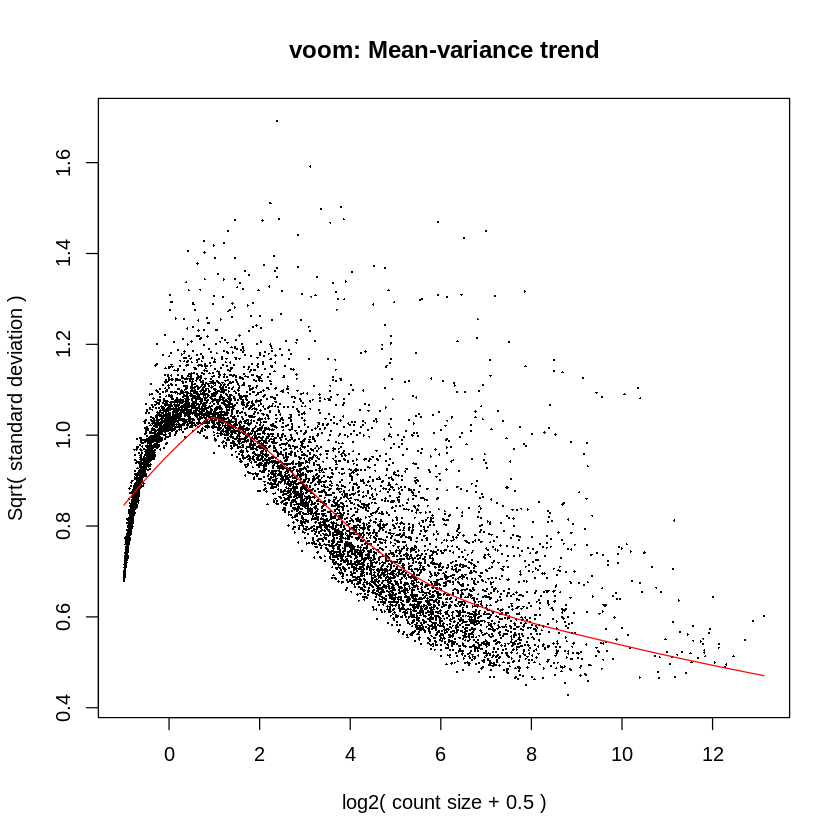


Genders new size
294

plotting y for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y_voom for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y for sjc portion of design <- model.matrix( ~sex + as_event + sex*as_event


 sex_as_events
DDX3X-5712 DDX3X-5710 DDX3X-5711 ASAH1-8586 ASAH1-8591 ASAH1-8590

 ijc_sex_results
XIST-2252 XIST-2253 KDM5C-4857 DDX3X-5705 DDX3X-5704 DDX3X-5711

 sjc_sex_results
XIST-2252 XIST-2253 DDX3X-5706 DDX3X-5705 KDM5C-4857 DDX3X-5708


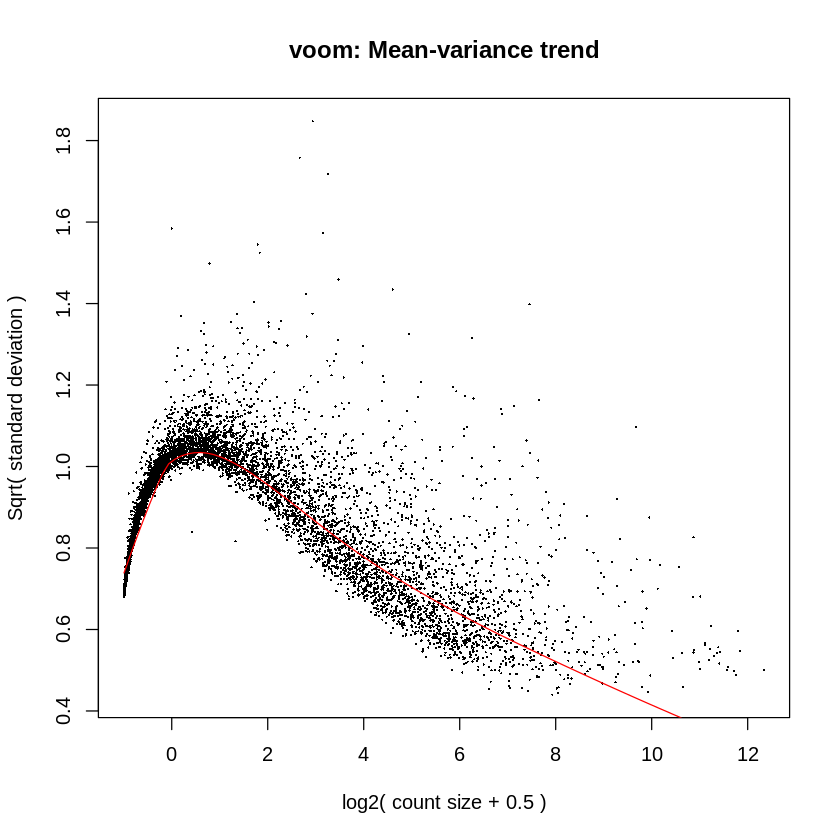

[1] 0

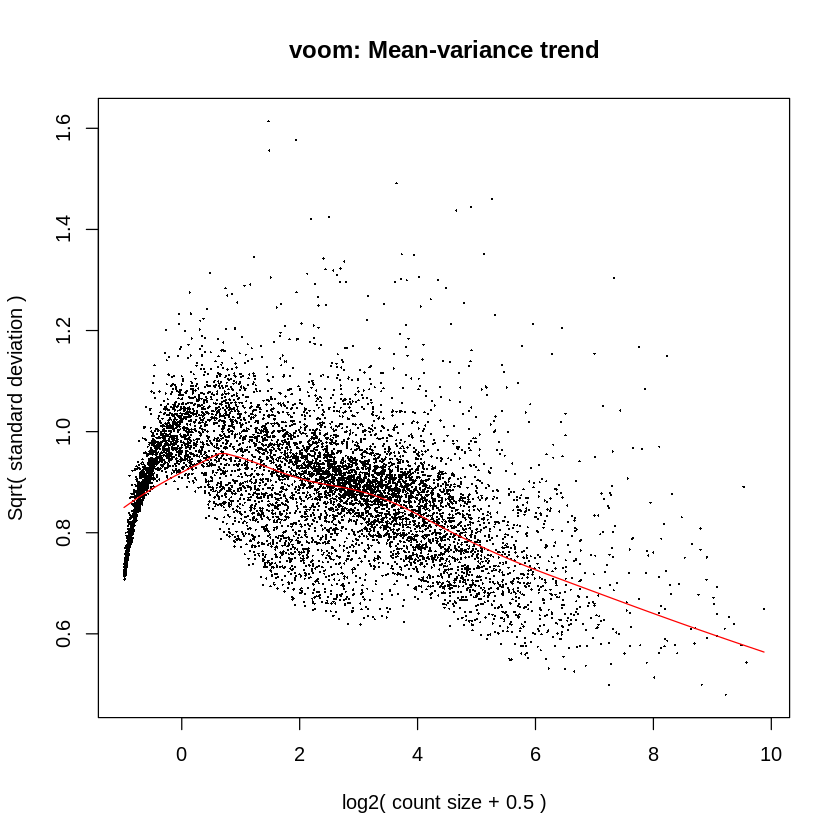

In [32]:
    # a3ss
    splice_type = "a3ss_"
    res = splice_list %in% splice_type
    tissue_of_interest  = as.vector(as.character(tissue_list[tissue_index]))

    if (sum(res) == 1) {
        message ("splice_list does contain\n",
             paste(splice_type), " continuing with processing\n")
        fromGTF    <- read.table("../data/fromGTF.A3SS.txt", header=TRUE)
        fromGTF    <- eliminateChrYfromGTF (fromGTF)
        ijc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.a3ss.jc.ijc.txt.gz")
        ijc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- ijc_counts)
        ijc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- ijc)
        ijc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- ijc)
        sjc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.a3ss.jc.sjc.txt.gz")
        sjc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- sjc_counts)
        sjc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- sjc)
        sjc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- sjc)
        print_exploratory_plots (plot, 
                                 dup, 
                                 tissue_of_interest, 
                                 splice_type, 
                                 fromGTF, 
                                 tissue_list, 
                                 ijc, 
                                 sjc)
 
    }


splice_list does contain
a5ss_ continuing with processing


loading ../data/rmats_final.a5ss.jc.ijc.txt.gz 
done!
making splicing expressionSet object
made new expressionSet object
55847872 
dim pData(es)
787268 
dim exprs(es)
55847872 
done!


size tissue_reduction
50 5

size es
55847872 

size pData(es)
7872 68

 number of tissue types to keep
1139 

length tissues in phenotype data
53

length tissues in tissue_reduction data
39

how many to keep in phenotype data
852 7020

size reduced es
55847020 

size pData(es)
7020 68

size exprs(es)
5584 7020

TEST: how many to keep in to have only breast_mammary_tissue
6842 178

TEST: size breast_mammary_tissue tes
5584 178

TEST: size phenotype object pData(tes)
178 68
remade the expressionSet object
55747020 
dim pData(es)
702068 
dim exprs(es)
55747020 
done!


loading ../data/rmats_final.a5ss.jc.sjc.txt.gz 
done!
making splicing expressionSet object
made new expressionSet object
55847872 
dim pData(es)
787268 
dim exprs(es)
55847872 
done!

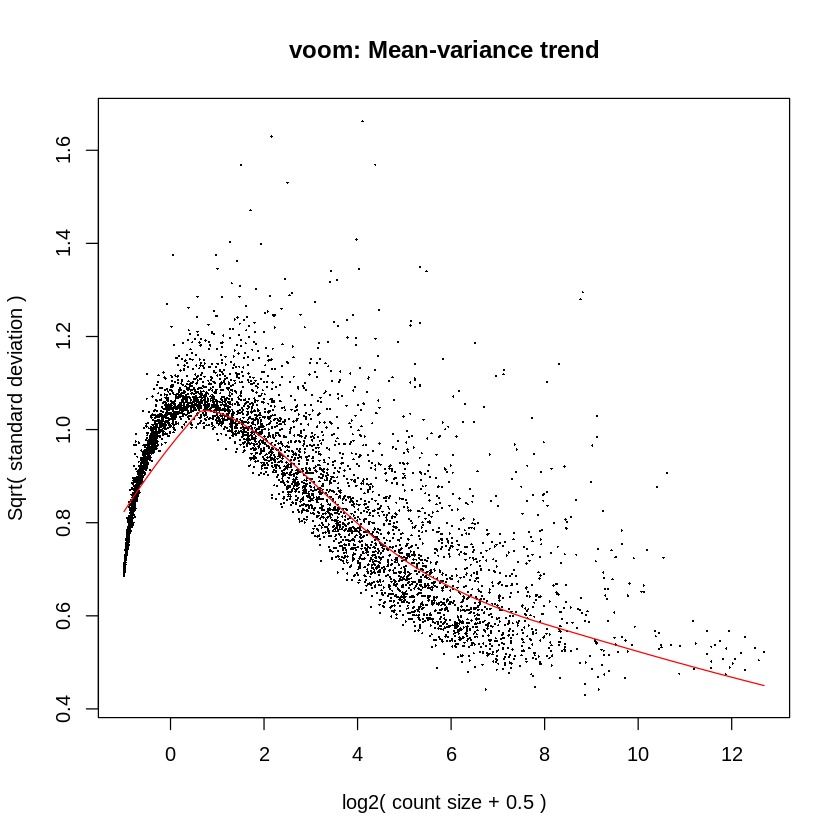


Genders new size
294

plotting y for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y_voom for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y for sjc portion of design <- model.matrix( ~sex + as_event + sex*as_event


 sex_as_events
DDX3X-3516 DDX3X-3517 ASAH1-5355 RPS2-2301 KLC1-2007 ARL8B-2675

 ijc_sex_results
KDM6A-2942 KDM5C-2989 DDX3X-3516 SAA1-289 SAA2-461 PUDP-4749

 sjc_sex_results
KDM5C-2989 DDX3X-3520 SAA1-289 DDX3X-3518 SAA2-461 CPAMD8-640


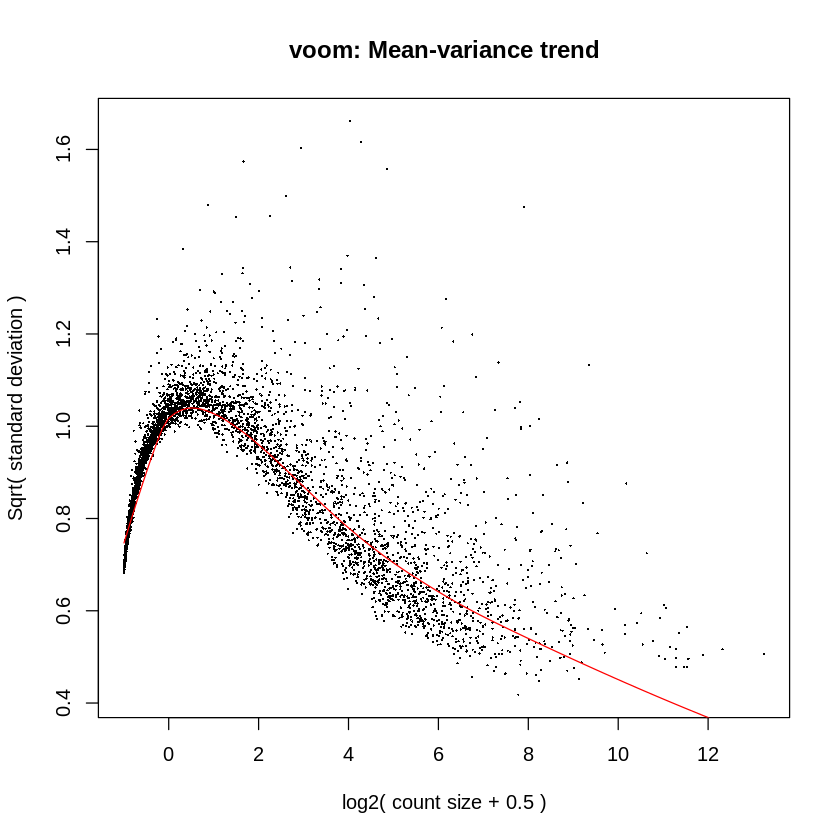

[1] 0

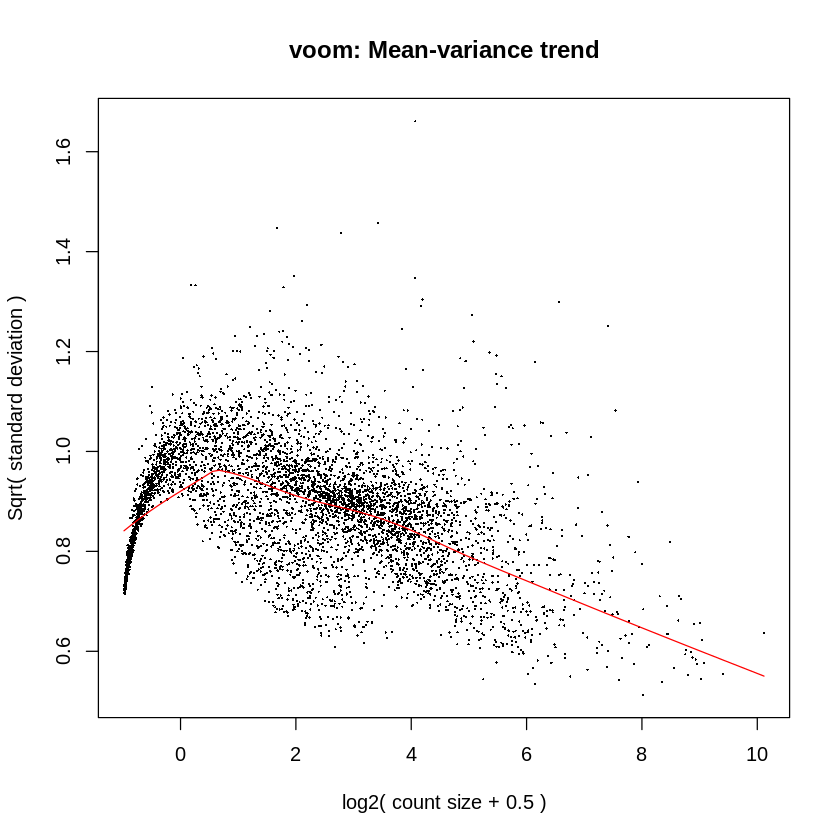

In [33]:
    # a5ss
    splice_type = "a5ss_"
    res = splice_list %in% splice_type
    tissue_of_interest  = as.vector(as.character(tissue_list[tissue_index]))

    if (sum(res) == 1) {
        message ("splice_list does contain\n",
             paste(splice_type), " continuing with processing\n")
        fromGTF    <- read.table("../data/fromGTF.A5SS.txt", header=TRUE)
        fromGTF    <- eliminateChrYfromGTF (fromGTF)
        ijc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.a5ss.jc.ijc.txt.gz")
        ijc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- ijc_counts)
        ijc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- ijc)
        ijc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- ijc)
        sjc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.a5ss.jc.sjc.txt.gz")
        sjc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- sjc_counts)
        sjc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- sjc)
        sjc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- sjc)
        print_exploratory_plots (plot, 
                                 dup, 
                                 tissue_of_interest, 
                                 splice_type, 
                                 fromGTF, 
                                 tissue_list, 
                                 ijc, 
                                 sjc)
 
    }


splice_list does contain
mxe_ continuing with processing


loading ../data/rmats_final.mxe.jc.ijc.txt.gz 
done!
making splicing expressionSet object
made new expressionSet object
29797872 
dim pData(es)
787268 
dim exprs(es)
29797872 
done!


size tissue_reduction
50 5

size es
29797872 

size pData(es)
7872 68

 number of tissue types to keep
1139 

length tissues in phenotype data
53

length tissues in tissue_reduction data
39

how many to keep in phenotype data
852 7020

size reduced es
29797020 

size pData(es)
7020 68

size exprs(es)
2979 7020

TEST: how many to keep in to have only breast_mammary_tissue
6842 178

TEST: size breast_mammary_tissue tes
2979 178

TEST: size phenotype object pData(tes)
178 68
remade the expressionSet object
29717020 
dim pData(es)
702068 
dim exprs(es)
29717020 
done!


loading ../data/rmats_final.mxe.jc.sjc.txt.gz 
done!
making splicing expressionSet object
made new expressionSet object
29797872 
dim pData(es)
787268 
dim exprs(es)
29797872 
done!




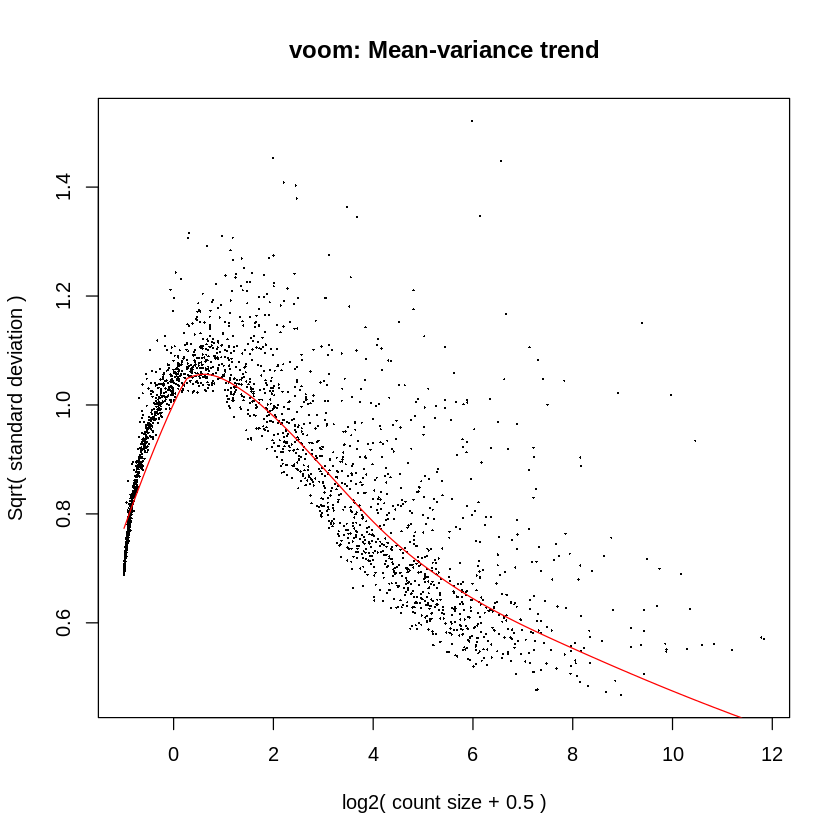


Genders new size
294

plotting y for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y_voom for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y for sjc portion of design <- model.matrix( ~sex + as_event + sex*as_event


 sex_as_events
DDX3X-1852 DDX3X-1853 NRG2-518 GCOM1-2558 AMZ2-2150 AMZ2-2151

 ijc_sex_results
XIST-768 DDX3X-1852 DDX3X-1853 DDX3X-1855 DDX3X-1854 GYG2-635

 sjc_sex_results
XIST-768 KDM6A-1586 DDX3X-1854 DDX3X-1855 JPX-2070 GYG2-635


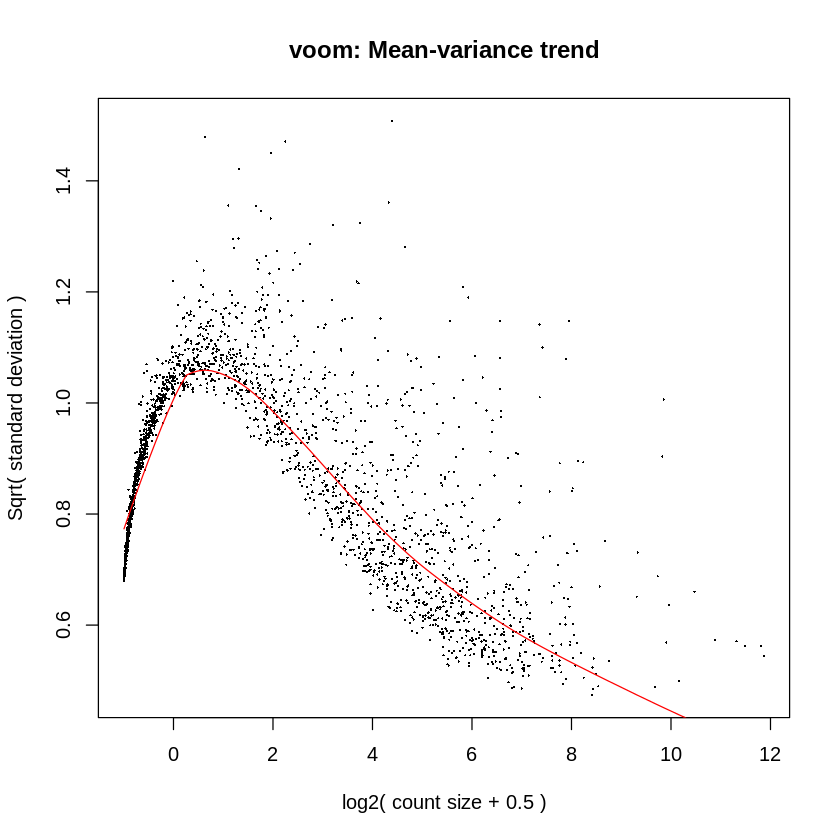

[1] 0

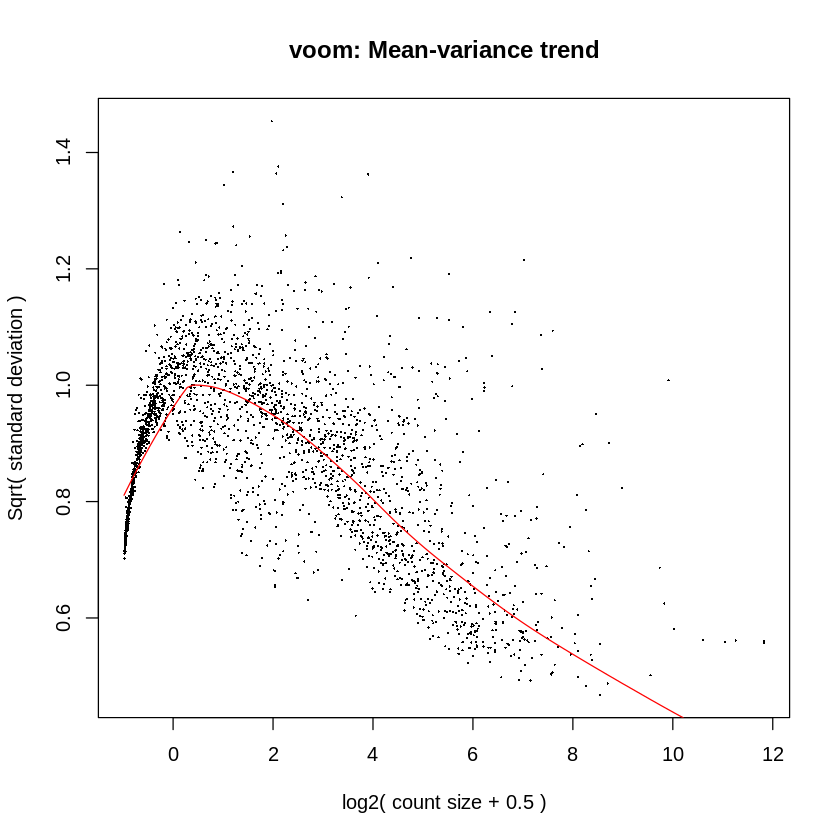

In [34]:
    # mxe
    splice_type = "mxe_"
    res = splice_list %in% splice_type
    tissue_of_interest  = as.vector(as.character(tissue_list[tissue_index]))

    if (sum(res) == 1) {
        message ("splice_list does contain\n",
             paste(splice_type), " continuing with processing\n")
        fromGTF    <- read.table("../data/fromGTF.MXE.txt", header=TRUE)
        fromGTF    <- eliminateChrYfromGTF (fromGTF)
        ijc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.mxe.jc.ijc.txt.gz")
        ijc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- ijc_counts)
        ijc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- ijc)
        ijc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- ijc)
        sjc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.mxe.jc.sjc.txt.gz")
        sjc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- sjc_counts)
        sjc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- sjc)
        sjc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- sjc)
        print_exploratory_plots (plot, 
                                 dup, 
                                 tissue_of_interest, 
                                 splice_type, 
                                 fromGTF, 
                                 tissue_list, 
                                 ijc, 
                                 sjc)
 
    }


splice_list does contain
ri_ continuing with processing


loading ../data/rmats_final.ri.jc.ijc.txt.gz 
done!
making splicing expressionSet object
made new expressionSet object
63127872 
dim pData(es)
787268 
dim exprs(es)
63127872 
done!


size tissue_reduction
50 5

size es
63127872 

size pData(es)
7872 68

 number of tissue types to keep
1139 

length tissues in phenotype data
53

length tissues in tissue_reduction data
39

how many to keep in phenotype data
852 7020

size reduced es
63127020 

size pData(es)
7020 68

size exprs(es)
6312 7020

TEST: how many to keep in to have only breast_mammary_tissue
6842 178

TEST: size breast_mammary_tissue tes
6312 178

TEST: size phenotype object pData(tes)
178 68
remade the expressionSet object
62977020 
dim pData(es)
702068 
dim exprs(es)
62977020 
done!


loading ../data/rmats_final.ri.jc.sjc.txt.gz 
done!
making splicing expressionSet object
made new expressionSet object
63127872 
dim pData(es)
787268 
dim exprs(es)
63127872 
done!


siz

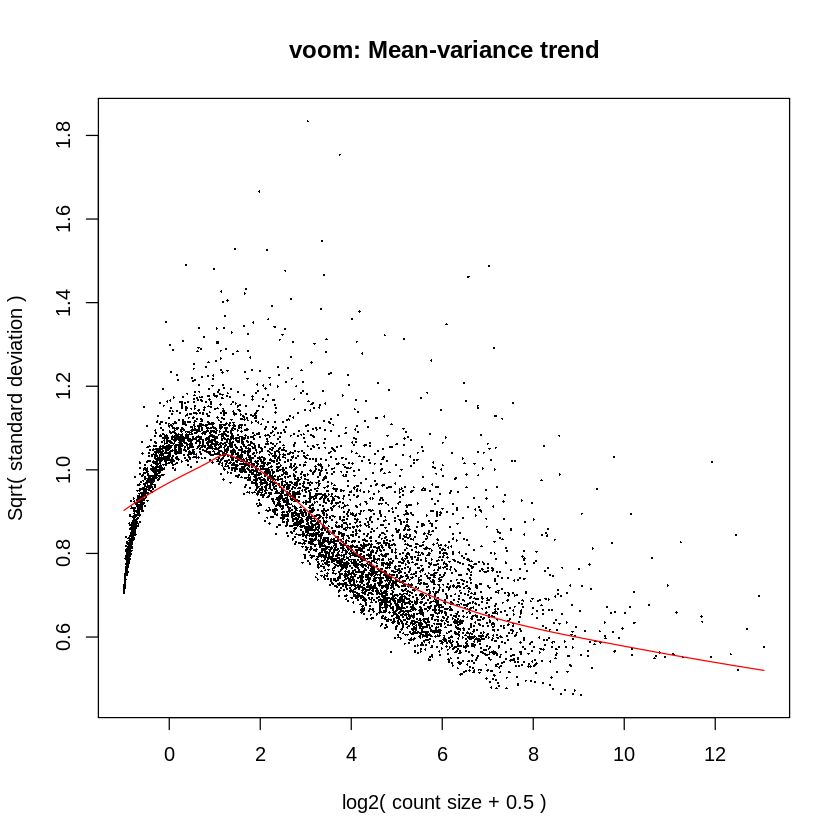


Genders new size
294

plotting y for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y_voom for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y for sjc portion of design <- model.matrix( ~sex + as_event + sex*as_event


 sex_as_events
DDX3X-4000 METTL3-5038 ASAH1-6088 ASAH1-6087 ACAD11-923 RPS4X-750

 ijc_sex_results
KDM5C-3369 RPS4X-750 AP000547.3-4370 DDX3X-3996 CPAMD8-718 DDX3X-4001

 sjc_sex_results
RPS4X-750 KDM5C-3369 DDX3X-3991 DDX3X-3987 DDX3X-3988 DDX3X-3993


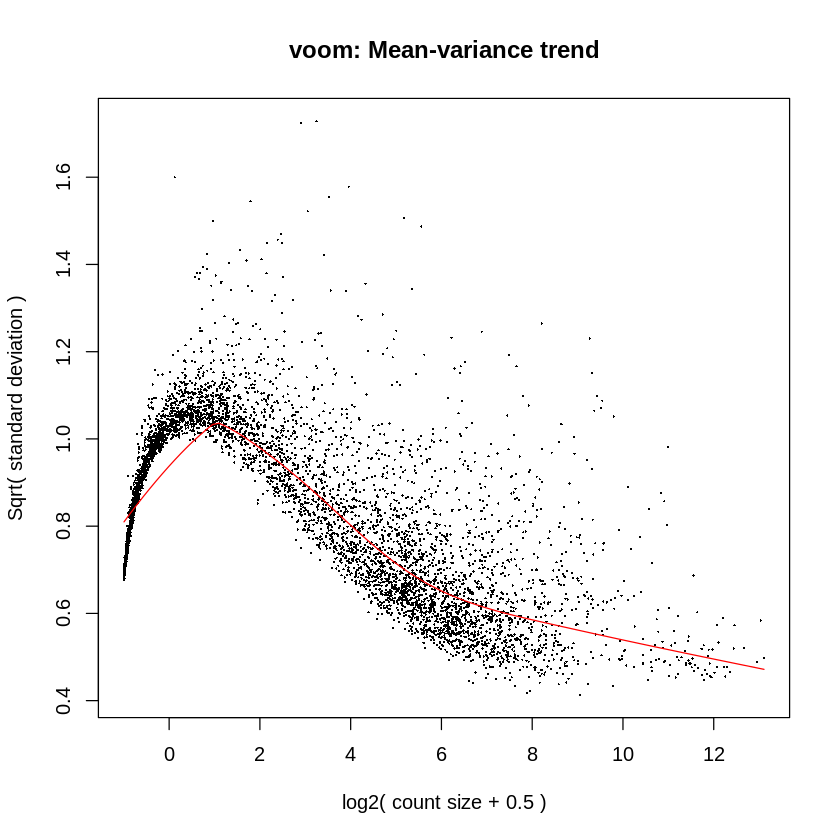

[1] 0

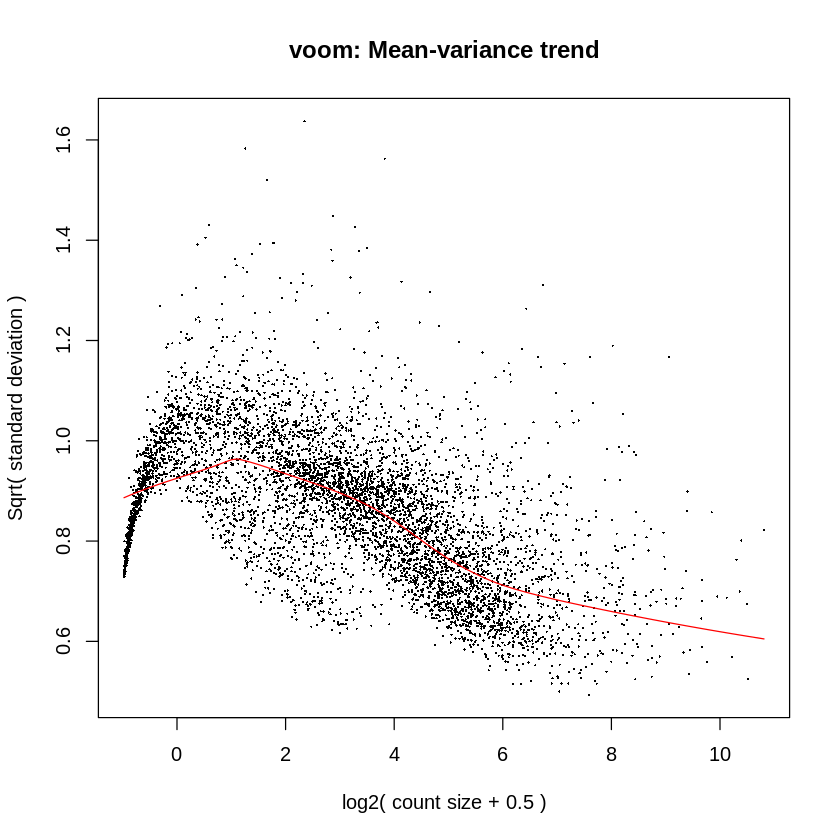

In [35]:
    # ri
    splice_type = "ri_"
    res = splice_list %in% splice_type
    tissue_of_interest  = as.vector(as.character(tissue_list[tissue_index]))

    if (sum(res) == 1) {
        message ("splice_list does contain\n",
             paste(splice_type), " continuing with processing\n")
        fromGTF    <- read.table("../data/fromGTF.RI.txt", header=TRUE)
        fromGTF    <- eliminateChrYfromGTF (fromGTF)
        ijc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.ri.jc.ijc.txt.gz")
        ijc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- ijc_counts)
        ijc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- ijc)
        ijc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- ijc)
        sjc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.ri.jc.sjc.txt.gz")
        sjc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- sjc_counts)
        sjc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- sjc)
        sjc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- sjc)
        print_exploratory_plots (plot, 
                                 dup, 
                                 tissue_of_interest, 
                                 splice_type, 
                                 fromGTF, 
                                 tissue_list, 
                                 ijc, 
                                 sjc)
 
    }

splice_list does contain
se_ continuing with processing


loading ../data/rmats_final.se.jc.ijc.txt.gz 
done!
making splicing expressionSet object
made new expressionSet object
426117872 
dim pData(es)
787268 
dim exprs(es)
426117872 
done!


size tissue_reduction
50 5

size es
426117872 

size pData(es)
7872 68

 number of tissue types to keep
1139 

length tissues in phenotype data
53

length tissues in tissue_reduction data
39

how many to keep in phenotype data
852 7020

size reduced es
426117020 

size pData(es)
7020 68

size exprs(es)
42611 7020

TEST: how many to keep in to have only breast_mammary_tissue
6842 178

TEST: size breast_mammary_tissue tes
42611 178

TEST: size phenotype object pData(tes)
178 68
remade the expressionSet object
424847020 
dim pData(es)
702068 
dim exprs(es)
424847020 
done!


loading ../data/rmats_final.se.jc.sjc.txt.gz 
done!
making splicing expressionSet object
made new expressionSet object
426117872 
dim pData(es)
787268 
dim exprs(es)
426117872 
d

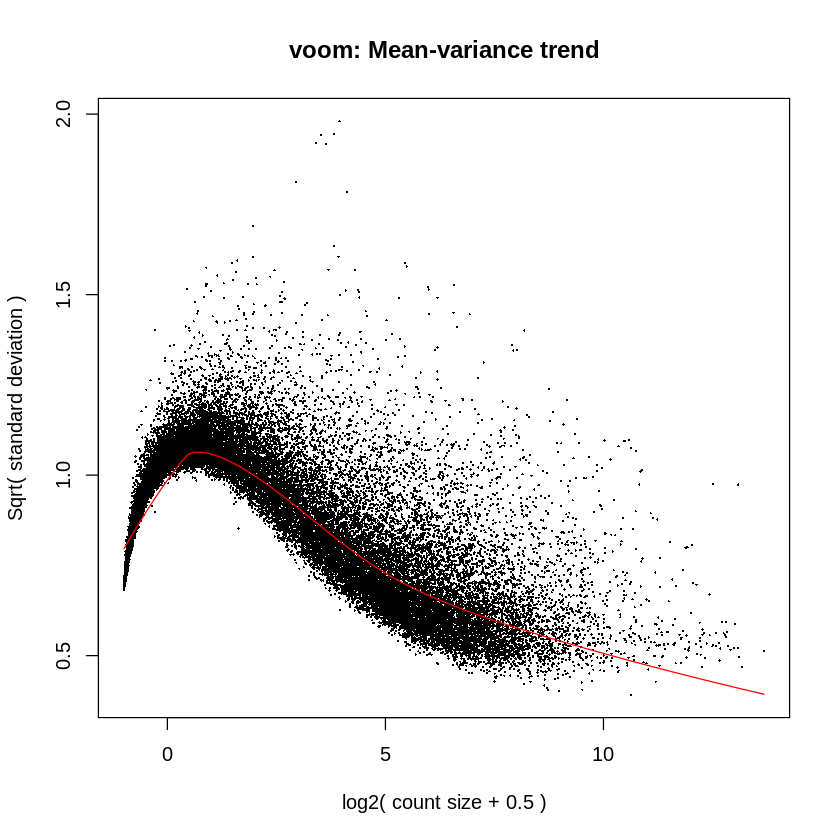


Genders new size
294

plotting y for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y_voom for ijc portion of design <- model.matrix( ~sex + as_event + sex*as_event


plotting y for sjc portion of design <- model.matrix( ~sex + as_event + sex*as_event


 sex_as_events
KDM5C-22847 ZFX-13700 DDX3X-26782 ZFX-13702 KDM5C-22848 DDX3X-26773

 ijc_sex_results
XIST-10151 XIST-10150 XIST-10155 XIST-10153 XIST-10154 XIST-10149

 sjc_sex_results
XIST-10150 XIST-10152 XIST-10151 XIST-10153 XIST-10155 KDM5C-22847


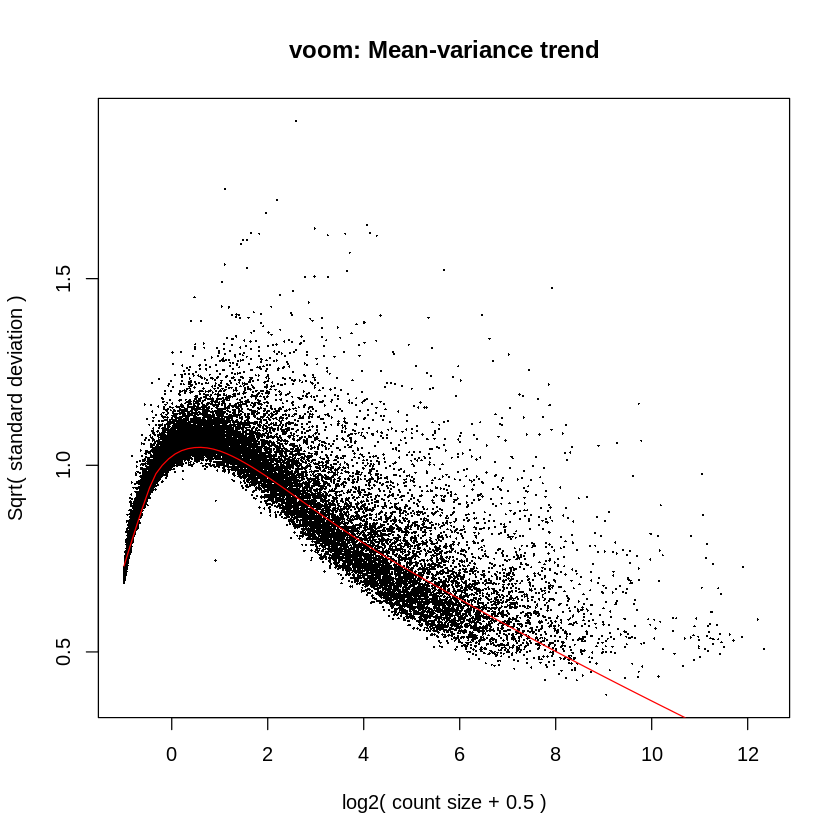

[1] 0

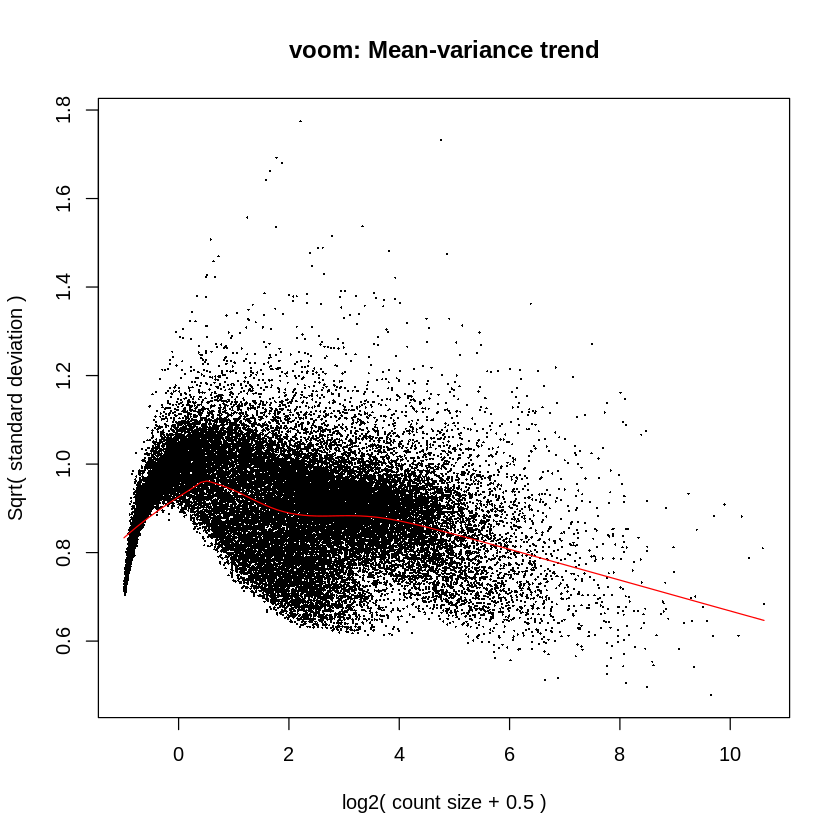

In [36]:
    # se
    splice_type = "se_"
    res = splice_list %in% splice_type
    tissue_of_interest  = as.vector(as.character(tissue_list[tissue_index]))

    if (sum(res) == 1) {
        message ("splice_list does contain\n",
             paste(splice_type), " continuing with processing\n")
        fromGTF    <- read.table("../data/fromGTF.SE.txt", header=TRUE)
        fromGTF    <- eliminateChrYfromGTF (fromGTF)
        ijc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.se.jc.ijc.txt.gz")
        ijc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- ijc_counts)
        ijc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- ijc)
        ijc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- ijc)
        sjc_counts <- makeCountsMatrix( filename_gz  <- "../data/rmats_final.se.jc.sjc.txt.gz")
        sjc        <- makeSplicingExpressionSetObject (srr_pdata <- srr_pdata, counts <- sjc_counts)
        sjc        <- reduceSampleSet(tissue_reduction <- tissue_reduction, es <- sjc)
        sjc        <- eliminateChrYfromExpressionSet (fromGTF <- fromGTF, es <- sjc)
        print_exploratory_plots (plot, 
                                 dup, 
                                 tissue_of_interest, 
                                 splice_type, 
                                 fromGTF, 
                                 tissue_list, 
                                 ijc, 
                                 sjc)
 
    }
#}

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [37]:
rm (notebookid)
notebookid   = "differentialSplicingJunctionExpressionAnalysis"
notebookid

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

paste0("../metadata/", notebookid, "_sha256sums.txt")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Warning message in rm(notebookid):
“object 'notebookid' not found”

[1] "differentialSplicingJunctionExpressionAnalysis"

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



[1] "../metadata/differentialSplicingJunctionExpressionAnalysis_sha256sums.txt"

sha256sum,file
<chr>,<chr>
a38b7b145b0db233ba6b83ea533a7e5c01ecdac868e46996d604c5707b6780c3,./liver_DGE.csv
4eaab8f5ac7336054b4362a09c82f670317b842b9f5f352efcf49011b6a5d5c1,./a3ss_whole_blood_DGE_sex_as_events_refined.csv
3ee0b9653d35496250df844627b6f7e2e9e9bfdad82ad1a1e75ff860a2d87eed,./esophagus_muscularis_DGE.csv
d9687683e53106bfa10da2be79f80f46f1180df75844d67c864f41cc939d0a06,./mxe_esophagus_muscularis_DGE_sex_as_events_refined.csv
01e26bcddec160ff640b05c0f92f63ecb7c1065969f7c12d410fb379122916b0,./brain_frontal_cortex_ba_9_DGE_ensg_map.csv
533fd5618a3df4c2d2a18bede39e1de85b67ff1d13d47353addd7316e0106078,./pituitary_DGE_refined.csv
d00d5acac08cf0ca0add846c3097674f728b41a8a33c853b7c00d27519daeb86,./brain_cortex_DGE_refined.csv
7d8360543ddc36935478cba7b042549c423d45aef7f1e00f4c6ea0873245b6d1,./a3ss_brain_hippocampus_DGE_sex_as_events_refined.csv
150d79c045deffb499df4eb827dfded1bc3e1a9813df33ba1e9448220e9ae280,./liver_DGE_ensg_map.csv


### 2. Libraries metadata

In [38]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-06-10                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
biomaRt,biomaRt,2.42.0,2.42.0,/opt/conda/lib/R/library/biomaRt,/opt/conda/lib/R/library/biomaRt,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
DBI,DBI,1.1.0,1.1.0,/opt/conda/lib/R/library/DBI,/opt/conda/lib/R/library/DBI,TRUE,FALSE,2019-12-15,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
devtools,devtools,2.0.2,2.0.2,/opt/conda/lib/R/library/devtools,/opt/conda/lib/R/library/devtools,TRUE,FALSE,2019-04-08,CRAN (R 3.6.0),NA,/opt/conda/lib/R/library
downloader,downloader,0.4,0.4,/opt/conda/lib/R/library/downloader,/opt/conda/lib/R/library/downloader,TRUE,FALSE,2015-07-09,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
gprofiler2,gprofiler2,0.1.9,0.1.9,/opt/conda/lib/R/library/gprofiler2,/opt/conda/lib/R/library/gprofiler2,TRUE,FALSE,2020-04-23,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
